In [81]:
import pandas as pd
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime

In [82]:
trainData_origin = pd.read_csv("train.csv")
trainData = trainData_origin.sample(n=7000, random_state=42)
trainData.head()
trainData.to_csv("train_data_subset.csv", index=False)

trainData = pd.read_csv("train_data_subset.csv")
trainData.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,212188,4300.0,3,16.99,153.29,D,D3,54.0,NaN,1,...,3.0,9.0,3.0,6.0,2.0,3.0,0.0,0.0,0.0,3.0
1,299036,28000.0,3,5.32,843.22,A,A1,160.0,10+ years,0,...,8.0,23.0,8.0,19.0,3.0,11.0,0.0,0.0,0.0,0.0
2,475978,13000.0,3,17.57,467.19,D,D4,6426.0,10+ years,0,...,10.0,21.0,9.0,15.0,6.0,18.0,0.0,0.0,0.0,5.0
3,588988,10000.0,3,7.59,311.48,A,A3,62512.0,3 years,1,...,4.0,4.0,6.0,8.0,5.0,6.0,0.0,0.0,0.0,1.0
4,138859,7000.0,3,10.08,226.14,B,B1,118.0,4 years,0,...,4.0,11.0,5.0,12.0,2.0,9.0,0.0,0.0,0.0,1.0


In [83]:
trainData.shape

(7000, 47)

In [84]:
#trainData = trainData.head(100000)

In [85]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  7000 non-null   int64  
 1   loanAmnt            7000 non-null   float64
 2   term                7000 non-null   int64  
 3   interestRate        7000 non-null   float64
 4   installment         7000 non-null   float64
 5   grade               7000 non-null   object 
 6   subGrade            7000 non-null   object 
 7   employmentTitle     7000 non-null   float64
 8   employmentLength    6580 non-null   object 
 9   homeOwnership       7000 non-null   int64  
 10  annualIncome        7000 non-null   float64
 11  verificationStatus  7000 non-null   int64  
 12  issueDate           7000 non-null   object 
 13  isDefault           7000 non-null   int64  
 14  purpose             7000 non-null   int64  
 15  postCode            7000 non-null   float64
 16  region

In [86]:
trainData["isDefault"].value_counts()

0    5663
1    1337
Name: isDefault, dtype: int64

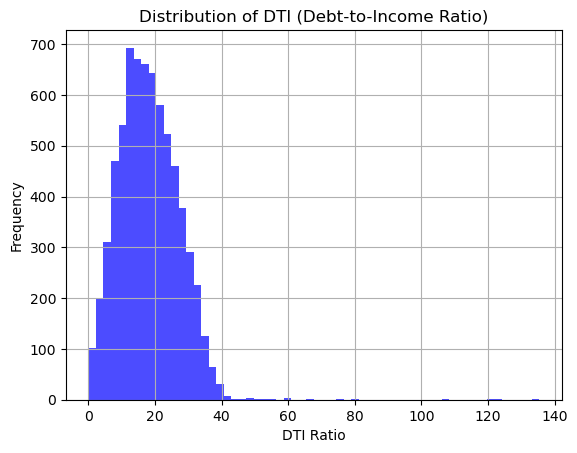

In [87]:
plt.hist(trainData['dti'], bins=60, color='blue', alpha=0.7)
plt.title('Distribution of DTI (Debt-to-Income Ratio)')
plt.xlabel('DTI Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [88]:
trainData['earliesCreditLine'] = pd.to_datetime(trainData['earliesCreditLine'], format='%b-%Y')

specific_now = pd.Timestamp('2023-12')

# 计算每个借款人从信用历史开始到特定日期（2023年12月）的月份数

# trainData['CreditHistoryLength_months'] = (specific_now.year - trainData['earliesCreditLine'].dt.year) * 12 + specific_now.month - trainData['earliesCreditLine'].dt.month
# trainData = trainData.drop(["earliesCreditLine"], axis = 1)

trainData['earliesCreditLine'] = (specific_now.year - trainData['earliesCreditLine'].dt.year) * 12 + specific_now.month - trainData['earliesCreditLine'].dt.month


trainData['issueDate'] = pd.to_datetime(trainData['issueDate'])
trainData['issueYear'] = trainData['issueDate'].dt.year
trainData['issueMonth'] = trainData['issueDate'].dt.month
trainData['issueDay'] = trainData['issueDate'].dt.day
trainData = trainData.drop(["issueDate"], axis = 1)


trainData['employmentLength'].fillna('0 years', inplace=True)


def convert_employment_length(length_str):
    if length_str.strip() == '10+ years':
        return 10  
    else:
        
        return int(length_str.strip().replace(' years', '').replace(' year', '').replace('< 1', '0'))


trainData['employmentLength'] = trainData['employmentLength'].apply(convert_employment_length)


grade_mapping = {
    'A': 7,
    'B': 6,
    'C': 5,
    'D': 4,
    'E': 3,
    'F': 2,
    'G': 1
}


trainData['grade'] = trainData['grade'].map(grade_mapping)

subgrade_mapping = {
    'A': 70,
    'B': 60,
    'C': 50,
    'D': 40,
    'E': 30,
    'F': 20,
    'G': 10,
}


def convert_grade(grade_str):
    if pd.isna(grade_str):
        return None  

    letter = grade_str[0]
    number = int(grade_str[1:])
 
    return subgrade_mapping[letter] + number - 1 

trainData['subGrade'] = trainData['subGrade'].apply(convert_grade)



min_loan_amt = int(np.floor(trainData['loanAmnt'].min() / 2000) * 2000)
max_loan_amt = int(np.ceil(trainData['loanAmnt'].max() / 2000) * 2000)


bins = list(range(min_loan_amt, max_loan_amt + 2000, 2000))


labels = [i + 2000 for i in bins[:-1]]  

trainData['loanAmnt_category'] = pd.cut(trainData['loanAmnt'], bins=bins, right=False, labels=labels)



trainData['loanAmnt_category'] = trainData['loanAmnt_category'].cat.add_categories(0)


trainData = trainData.fillna(0)
trainData['loanAmnt_category'] = trainData['loanAmnt_category'].astype(int)




In [89]:
trainData['loanAmnt_category']

0        6000
1       30000
2       14000
3       12000
4        8000
        ...  
6995    18000
6996    18000
6997     6000
6998     8000
6999    22000
Name: loanAmnt_category, Length: 7000, dtype: int32

In [90]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  7000 non-null   int64  
 1   loanAmnt            7000 non-null   float64
 2   term                7000 non-null   int64  
 3   interestRate        7000 non-null   float64
 4   installment         7000 non-null   float64
 5   grade               7000 non-null   int64  
 6   subGrade            7000 non-null   int64  
 7   employmentTitle     7000 non-null   float64
 8   employmentLength    7000 non-null   int64  
 9   homeOwnership       7000 non-null   int64  
 10  annualIncome        7000 non-null   float64
 11  verificationStatus  7000 non-null   int64  
 12  isDefault           7000 non-null   int64  
 13  purpose             7000 non-null   int64  
 14  postCode            7000 non-null   float64
 15  regionCode          7000 non-null   int64  
 16  dti   

# Finish data cleaning, create graph structure for data

1.  linking loans(nodes) based on credit grade

In [91]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from scipy.io import savemat

grouped = trainData.groupby('subGrade').apply(lambda x: x.index.to_numpy())


data = []
row_indices = []
col_indices = []


for indices in grouped:
    if len(indices) > 1:
        ix_grid = np.triu_indices(len(indices), 1)
        row_indices.append(indices[ix_grid[0]])
        col_indices.append(indices[ix_grid[1]])
        data.append(np.ones(len(indices[ix_grid[0]]), dtype=int))


data = np.concatenate(data)
row_indices = np.concatenate(row_indices)
col_indices = np.concatenate(col_indices)

max_index = trainData.index.max() + 1
adjacency_matrix_grade = coo_matrix((data, (row_indices, col_indices)), shape=(max_index, max_index))





In [92]:
mat_file_path = 'adjacency_grade.mat'
savemat(mat_file_path, {'net_tgt': adjacency_matrix_grade})


print(f"Adjacency matrix saved to {mat_file_path}")

Adjacency matrix saved to adjacency_grade.mat


In [93]:
print(adjacency_matrix_grade.shape)

(7000, 7000)


2.  linking loans(nodes) based on purpose

In [94]:
trainData["purpose"].unique()

array([ 0,  4,  2,  3,  5,  8,  6,  9, 11, 10,  7,  1, 12, 13],
      dtype=int64)

In [95]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from scipy.io import savemat

grouped = trainData.groupby('purpose').apply(lambda x: x.index.to_numpy())


data = []
row_indices = []
col_indices = []

for indices in grouped:
    if len(indices) > 1:
        
        ix_grid = np.triu_indices(len(indices), 1)
        row_indices.append(indices[ix_grid[0]])
        col_indices.append(indices[ix_grid[1]])
        data.append(np.ones(len(indices[ix_grid[0]]), dtype=int))


data = np.concatenate(data)
row_indices = np.concatenate(row_indices)
col_indices = np.concatenate(col_indices)

max_index = trainData.index.max() + 1
adjacency_matrix_purpose = coo_matrix((data, (row_indices, col_indices)), shape=(max_index, max_index))





In [96]:
print(adjacency_matrix_purpose.shape)

(7000, 7000)


In [97]:
mat_file_path = 'adjacency_purpose.mat'
savemat(mat_file_path, {'net_tpt': adjacency_matrix_purpose})

print(f"Adjacency matrix saved to {mat_file_path}")

Adjacency matrix saved to adjacency_purpose.mat


3.  linking loans(nodes) based on postCode

In [99]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from scipy.io import savemat

grouped = trainData.groupby('postCode').apply(lambda x: x.index.to_numpy())

data = []
row_indices = []
col_indices = []

for indices in grouped:
    if len(indices) > 1:
        ix_grid = np.triu_indices(len(indices), 1)
        row_indices.append(indices[ix_grid[0]])
        col_indices.append(indices[ix_grid[1]])
        data.append(np.ones(len(indices[ix_grid[0]]), dtype=int))

data = np.concatenate(data)
row_indices = np.concatenate(row_indices)
col_indices = np.concatenate(col_indices)

max_index = trainData.index.max() + 1
adjacency_matrix_geo = coo_matrix((data, (row_indices, col_indices)), shape=(max_index, max_index))


In [100]:
mat_file_path = 'adjacency_geo.mat'
savemat(mat_file_path, {'net_trt': adjacency_matrix_geo})

print(f"Adjacency matrix saved to {mat_file_path}")

Adjacency matrix saved to adjacency_geo.mat


4. linking loans(nodes) based on loan amount ranges

In [101]:
trainData["loanAmnt_category"]

0        6000
1       30000
2       14000
3       12000
4        8000
        ...  
6995    18000
6996    18000
6997     6000
6998     8000
6999    22000
Name: loanAmnt_category, Length: 7000, dtype: int32

In [102]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from scipy.io import savemat

grouped = trainData.groupby('loanAmnt_category').apply(lambda x: x.index.to_numpy())


data = []
row_indices = []
col_indices = []


for indices in grouped:
    if len(indices) > 1:
        ix_grid = np.triu_indices(len(indices), 1)
        row_indices.append(indices[ix_grid[0]])
        col_indices.append(indices[ix_grid[1]])
        data.append(np.ones(len(indices[ix_grid[0]]), dtype=int))


data = np.concatenate(data)
row_indices = np.concatenate(row_indices)
col_indices = np.concatenate(col_indices)


max_index = trainData.index.max() + 1
adjacency_matrix_loan = coo_matrix((data, (row_indices, col_indices)), shape=(max_index, max_index))

In [103]:
mat_file_path = 'adjacency_loamAmt.mat'
savemat(mat_file_path, {'net_tat': adjacency_matrix_loan})

print(f"Adjacency matrix saved to {mat_file_path}")

Adjacency matrix saved to adjacency_loamAmt.mat


5. store labels

In [104]:
trainData["isDefault"]

0       1
1       0
2       0
3       0
4       0
       ..
6995    0
6996    1
6997    0
6998    0
6999    0
Name: isDefault, Length: 7000, dtype: int64

In [105]:
from scipy.io import savemat

trainData_dict = {"label": trainData["isDefault"].values}
savemat("label.mat", trainData_dict)


In [106]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  7000 non-null   int64  
 1   loanAmnt            7000 non-null   float64
 2   term                7000 non-null   int64  
 3   interestRate        7000 non-null   float64
 4   installment         7000 non-null   float64
 5   grade               7000 non-null   int64  
 6   subGrade            7000 non-null   int64  
 7   employmentTitle     7000 non-null   float64
 8   employmentLength    7000 non-null   int64  
 9   homeOwnership       7000 non-null   int64  
 10  annualIncome        7000 non-null   float64
 11  verificationStatus  7000 non-null   int64  
 12  isDefault           7000 non-null   int64  
 13  purpose             7000 non-null   int64  
 14  postCode            7000 non-null   float64
 15  regionCode          7000 non-null   int64  
 16  dti   

In [107]:
trainData_features = trainData.drop(["id","isDefault"], axis = 1)
trainData_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loanAmnt            7000 non-null   float64
 1   term                7000 non-null   int64  
 2   interestRate        7000 non-null   float64
 3   installment         7000 non-null   float64
 4   grade               7000 non-null   int64  
 5   subGrade            7000 non-null   int64  
 6   employmentTitle     7000 non-null   float64
 7   employmentLength    7000 non-null   int64  
 8   homeOwnership       7000 non-null   int64  
 9   annualIncome        7000 non-null   float64
 10  verificationStatus  7000 non-null   int64  
 11  purpose             7000 non-null   int64  
 12  postCode            7000 non-null   float64
 13  regionCode          7000 non-null   int64  
 14  dti                 7000 non-null   float64
 15  delinquency_2years  7000 non-null   float64
 16  ficoRa

In [108]:
trainData_features.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n9,n10,n11,n12,n13,n14,issueYear,issueMonth,issueDay,loanAmnt_category
0,4300.0,3,16.99,153.29,4,42,54.0,0,1,86000.0,...,2.0,3.0,0.0,0.0,0.0,3.0,2014,10,1,6000
1,28000.0,3,5.32,843.22,7,70,160.0,10,0,106000.0,...,3.0,11.0,0.0,0.0,0.0,0.0,2015,10,1,30000
2,13000.0,3,17.57,467.19,4,43,6426.0,10,0,39000.0,...,6.0,18.0,0.0,0.0,0.0,5.0,2015,7,1,14000
3,10000.0,3,7.59,311.48,7,72,62512.0,3,1,50000.0,...,5.0,6.0,0.0,0.0,0.0,1.0,2016,7,1,12000
4,7000.0,3,10.08,226.14,6,60,118.0,4,0,50000.0,...,2.0,9.0,0.0,0.0,0.0,1.0,2018,8,1,8000


In [109]:
feature_matrix = trainData_features.values
feature_matrix

from scipy import io as sio
sio.savemat('trainData_features.mat', {'features': feature_matrix})


In [110]:
from scipy.sparse import csr_matrix, hstack
homo_matrix = hstack([adjacency_matrix_grade, adjacency_matrix_purpose,adjacency_matrix_geo,adjacency_matrix_loan])

In [111]:
print(homo_matrix.toarray()[:5, :5]) 


[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [112]:
combined_matrix = adjacency_matrix_grade + adjacency_matrix_purpose + adjacency_matrix_geo + adjacency_matrix_loan
combined_matrix.data[combined_matrix.data > 1] = 1

In [113]:
print(combined_matrix.toarray()[:5, :5])

[[0 1 1 1 1]
 [0 0 1 1 1]
 [0 0 0 1 1]
 [0 0 0 0 1]
 [0 0 0 0 0]]


In [114]:
mat_file_path = 'homo_matrix.mat'

savemat(mat_file_path, {'homo': combined_matrix})

In [115]:
mat_file_path = 'AlibabaLoan.mat'

label_array = trainData["isDefault"].values.astype(int)

matrices_dict = {
    'features': feature_matrix,
    'label':label_array,
    'homo': combined_matrix,
    'net_tgt': adjacency_matrix_grade,
    'net_tpt': adjacency_matrix_purpose,
    'net_trt': adjacency_matrix_geo,
    'net_tat': adjacency_matrix_loan,
}
savemat(mat_file_path, matrices_dict)